# Investigation of the numpy.random package

In [7]:
import numpy as np
import matplotlib.pyplot as pl

## Problem 1: Overall package purpose

## Problem 2: Simple Random Data and Permutations

### numpy.random.rand

Random values in the interval [0, 1)

(array([101., 104.,  98.,  99.,  97., 106., 101.,  91., 107.,  96.]),
 array([0.00234297, 0.10208435, 0.20182573, 0.3015671 , 0.40130848,
        0.50104986, 0.60079124, 0.70053262, 0.80027399, 0.90001537,
        0.99975675]),
 <a list of 10 Patch objects>)

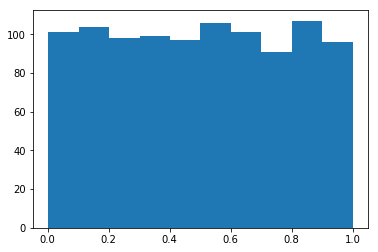

In [10]:
x = np.random.rand(1000)
pl.hist(x)

### numpy.random.randn¶

Random sample of normal/Gaussian distribution

In [13]:
np.random.randn()

-0.6826418024009379

In [12]:
2.5 * np.random.randn(2, 4) + 3

array([[3.45121319, 1.04590511, 1.409075  , 3.03281005],
       [5.49603731, 2.50131072, 6.83760075, 4.68648879]])

### numpy.random.randint
Random integers

In [14]:
np.random.randint(2, size=10)

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [15]:
np.random.randint(1, size=10)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [23]:
np.random.randint(0, 20, size=(3, 3))

array([[15,  5, 11],
       [16, 13,  0],
       [ 7, 15,  3]])